In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import gc
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification
from transformers import  get_linear_schedule_with_warmup
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer, seed_everything
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, matthews_corrcoef, roc_auc_score, f1_score
from scipy.special import softmax
from Bio import SeqIO
from preprocess.utils import Sequence, DNASequence, KmerSequence, compute_all_metrics
from model.bertnup import Dnabert1Dataset
from model.attention import visualize_token2token_scores, format_attention, process_attention_score, get_real_score, BertNupAttention, BertNup

In [2]:
import random
def set_seed(seed):
    """ Set all seeds to make results reproducible (deterministic mode).
        When seed is a false-y value or not supplied, disables deterministic mode. """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(0)

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Loading pre-trained model and data

Download the checkpoint for a sample pre-trained model via:
- https://drive.google.com/file/d/1yz-nZ45CHNqOTbMVnuZys36Fp9Xj-NLN/view?usp=sharing

Put the checkpoint under `model_checkpoint/dnabert-1-3_pretrained.ckpt` to run the following cells.

In [6]:
K = 3
model_name = 'armheb/DNA_bert_' + str(K)
tokenizer = AutoTokenizer.from_pretrained(model_name)
saved_model = 'pretrained_dnabert-1-3'

bert_nup = BertNup(model_name)
bert_nup = BertNup.load_from_checkpoint('model_checkpoint/dnabert-1-3_pretrained.ckpt', model_name=model_name, strict=False)
bert_nup.dnabert.save_pretrained(saved_model)
bert_model = BertForSequenceClassification.from_pretrained(saved_model, local_files_only = True, output_attentions = True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at armheb/DNA_bert_3 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\Admin\OneDrive\Desktop\github BertNup\model_checkpoint\dnabert-1-3_pretrained.ckpt`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at armheb/DNA_bert_3 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\anaconda\lib\site-packages\pytorch_lightning\core\saving.py:255: UserWarning: Found keys that are not in the model state d

In [7]:
test_params = {'batch_size': 128,
                'shuffle': False,
                'num_workers': 0
                }

data_dir = 'Data/Stratified_K_fold_data/HS_LC/split_0/'
test_path = data_dir + 'test.csv'
test_set = Dnabert1Dataset(test_path, K)
test_loader = DataLoader(test_set, **test_params)
trainer = Trainer(accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Visualize attention scores for a single sequence

Label:  0


[]

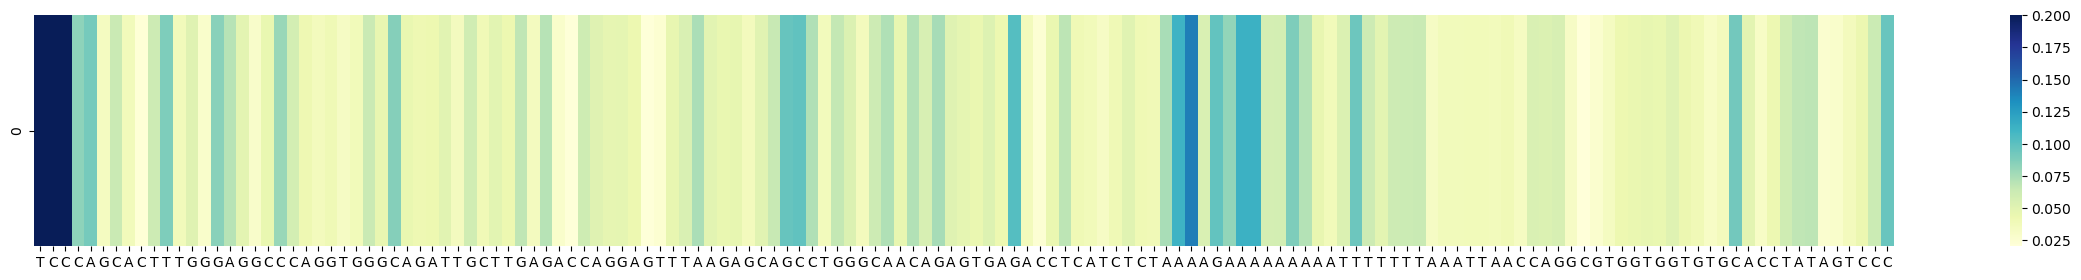

In [9]:
sequence_idx = 10000

print('Label: ',test_set.data.label[sequence_idx])
BertNup_attn = BertNupAttention(saved_model)
final_attn_scores = BertNup_attn(test_set[sequence_idx]['input_ids'].view(1,-1),test_set[sequence_idx]['attention_mask'].view(1,-1)).detach().numpy().reshape(1,-1)

plt.figure(figsize = (30,3))
sns.heatmap(final_attn_scores, cmap='YlGnBu',vmax = 0.2,
            xticklabels=list(test_set.data.sequence[sequence_idx].upper()),
            )
plt.plot()

### Visualize attention scores for the whole test set

In [11]:
BertNup_attn = BertNupAttention(saved_model)
attn_scores = trainer.predict(model = BertNup_attn, dataloaders = test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [12]:
all_attn_scores = torch.cat(attn_scores, dim=0)
processed_scores = []
for i,attn_score in enumerate(list(all_attn_scores)):
    if i%10000 == 0:
        print(i)
    processed_scores.append(process_attention_score(attn_score, kmer=K))
final_attn_scores = np.concatenate(processed_scores, axis = 0)

pos_attn = final_attn_scores[test_set.data.label == 1,:]
neg_attn = final_attn_scores[test_set.data.label == 0,:]

0
10000


[]

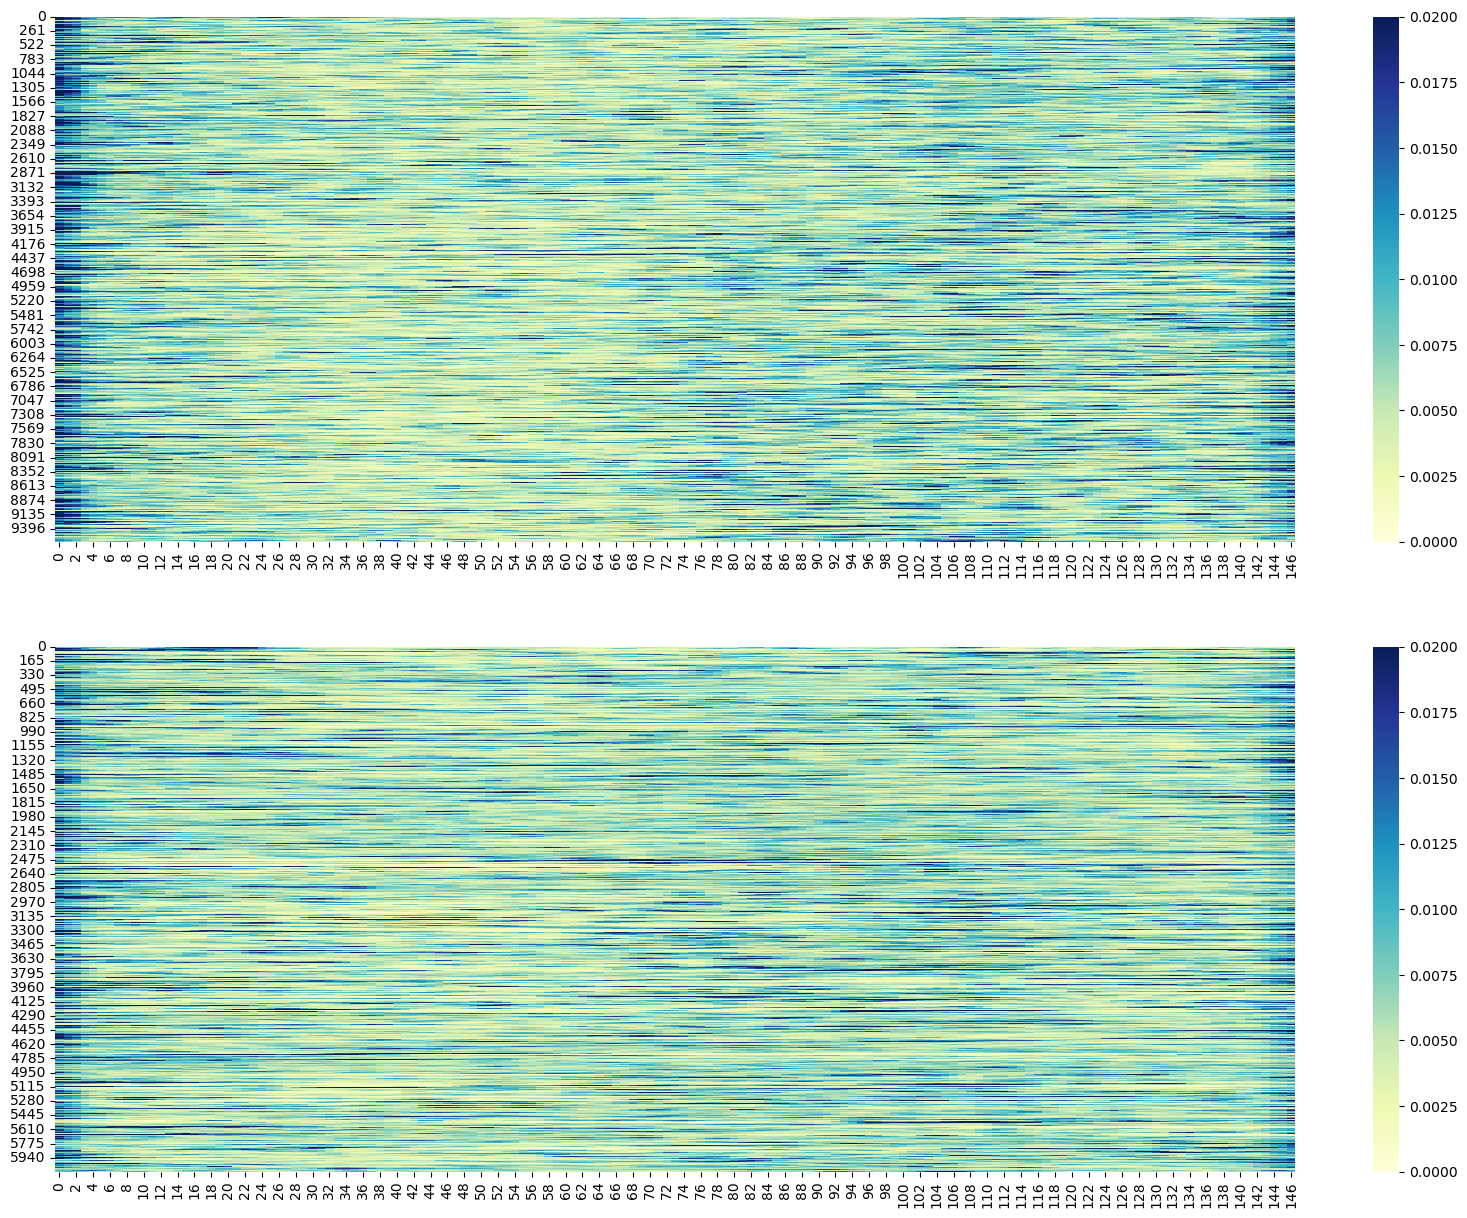

In [13]:
fig, axs = plt.subplots(2,1,figsize = (20,15))
sns.heatmap(pos_attn, cmap='YlGnBu', vmin=0, vmax = 0.02,
            ax = axs[0])
sns.heatmap(neg_attn, cmap='YlGnBu', vmin=0, vmax = 0.02,
            ax = axs[1])
plt.plot()

### Compute average attention score by sequence position

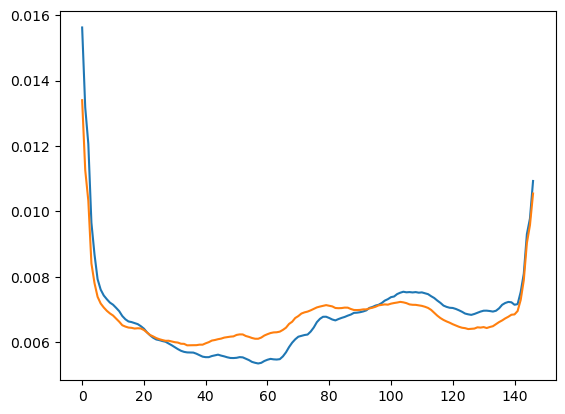

In [14]:
ave1 = np.sum(pos_attn, axis = 0)/pos_attn.shape[0]
ave0 = np.sum(neg_attn, axis = 0)/neg_attn.shape[0]
plt.plot(ave1)
plt.plot(ave0)

### Visualize attention map for each head

Label:  1


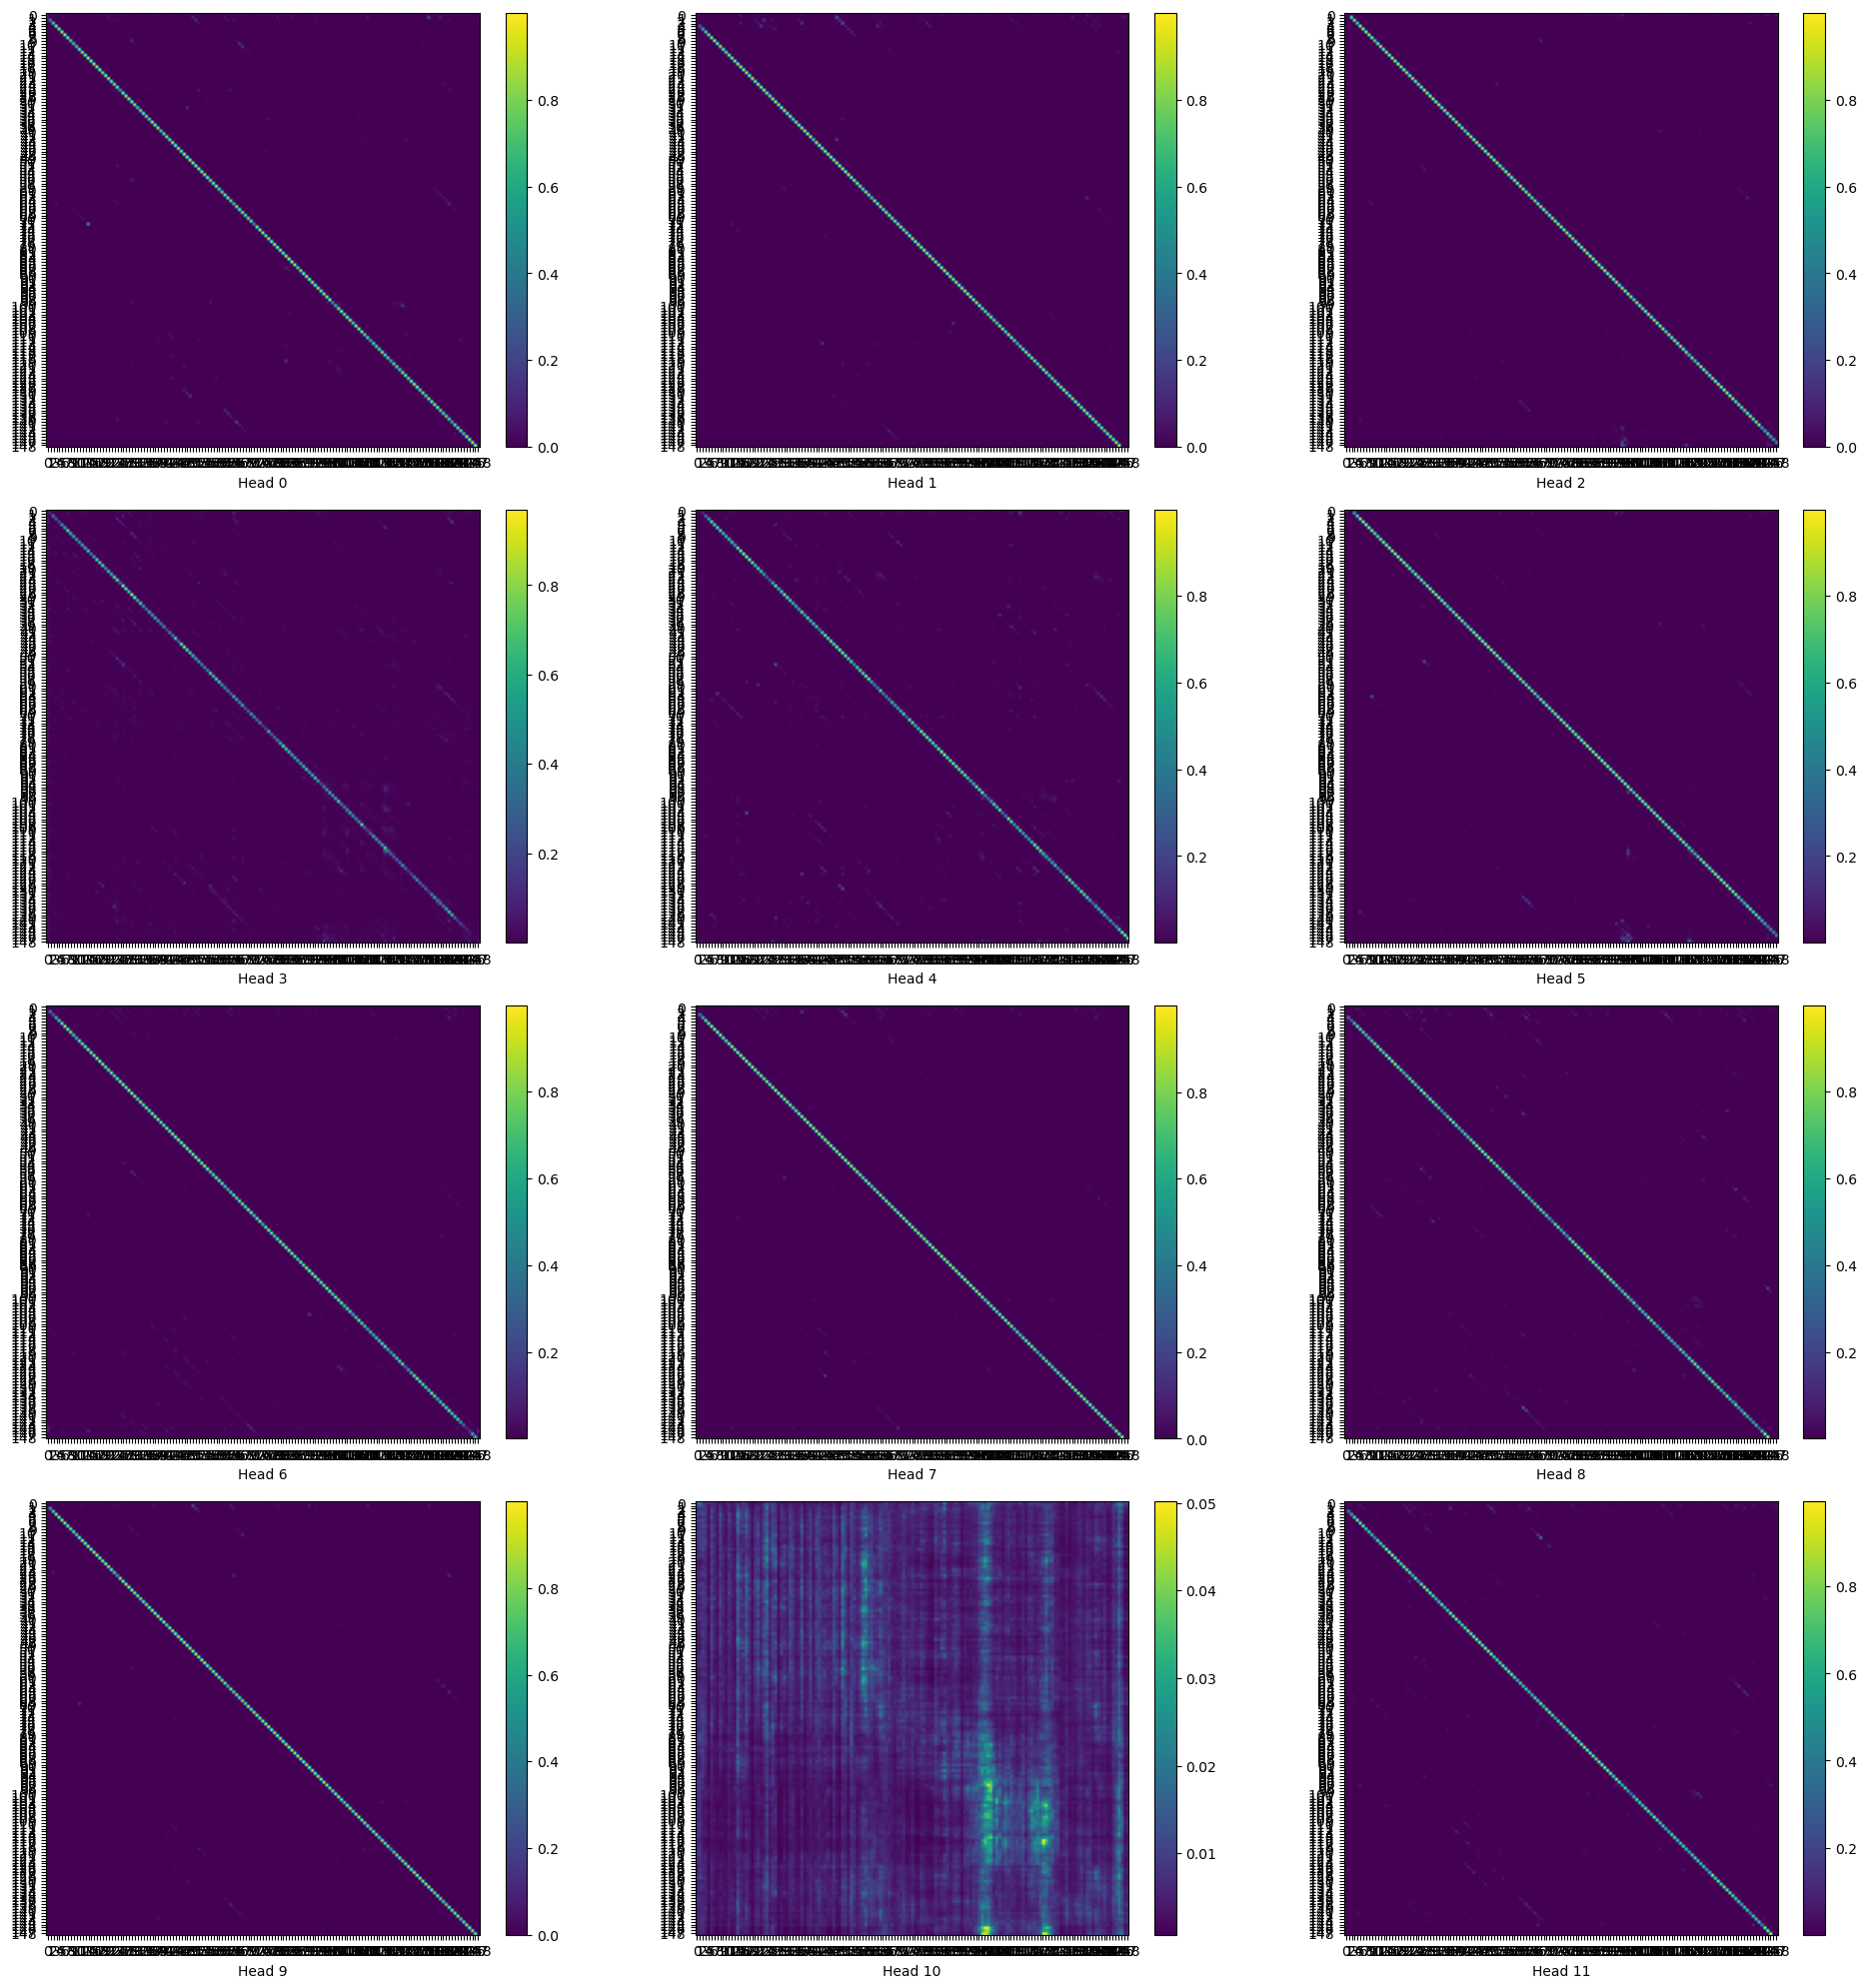

In [16]:
sequence_idx = 10
layer = 11  # layer can be in range(0,11)
head = None # head can be in range(0,11) or None (will visualize all heads in a layer)

inputs = tokenizer.encode(str(DNASequence(test_set.data.sequence[sequence_idx]).to_kmer_sequence(K)), return_tensors='pt')
attention = bert_model(inputs)[-1]
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 
xticks = ['CLS'] + list(test_set.data.sequence[sequence_idx].upper()) + ['SEP']
print('Label: ', test_set.data.label[sequence_idx])
output_attentions_all = torch.stack(attention)

visualize_token2token_scores(output_attentions_all[layer].squeeze().detach().cpu().numpy(), head = head, xticks = xticks)